# Import Libraries

In [642]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 

In [643]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [644]:
# read csv file into pandas
df = pd.read_csv("../datasets/question6.csv")
df.head(3)

,question_id,answer,grade
0,6,نصف قرن,0
1,6,ثلث قرن,0
2,6,ثلث قرن,0


# EDA

In [645]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  138 non-null    int64 
 1   answer       138 non-null    object
 2   grade        138 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ KB


In [646]:
df.groupby('grade').size()

grade
0    46
1    45
2    47
dtype: int64

In [647]:
df.duplicated().sum()

17

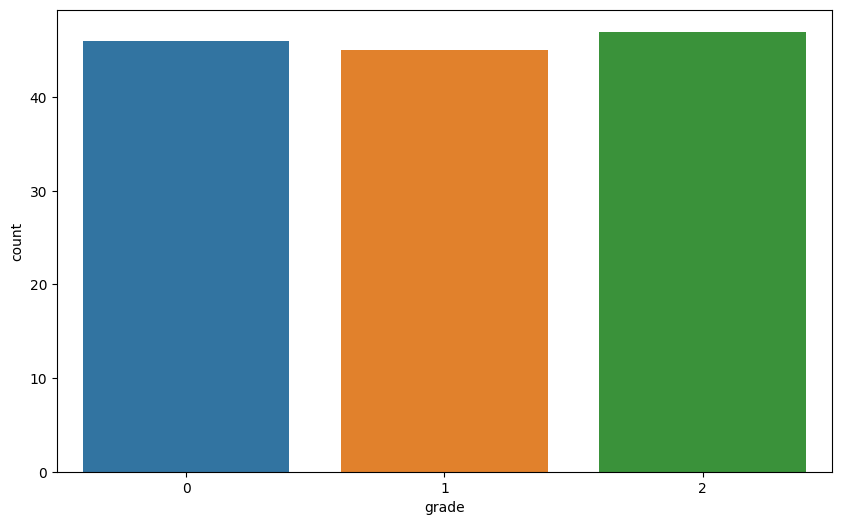

In [648]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

# Data Cleaning

In [649]:
df.drop('question_id', axis=1, inplace=True)

In [650]:
df.dropna(inplace=True)

In [651]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [652]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [653]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [654]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=10, min_count=1, workers=4)

In [655]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [656]:
df.head()

,answer,grade,tokens,textvector
0,نصف قرن,0,"[نصف, قرن]","[-0.015311817, -0.0036361269, 0.0034816258, 0...."
1,ثلث قرن,0,"[ثلث, قرن]","[-0.0144258775, 0.0042421063, 0.0060408665, 0...."
4,عشر سنوات,0,"[عشر, سنوات]","[-0.0053579286, 0.004851368, -0.0049733343, 0...."
6,عشر سنوات,0,"[عشر, سنوات]","[-0.0053579286, 0.004851368, -0.0049733343, 0...."
7,خمسة وعشرون سنة,2,"[خمسة, وعشرون, سنة]","[0.009277042, -0.00037817005, 0.013898757, -0...."


# split the data

In [657]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [658]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[-5.3579286e-03  4.8513678e-03 -4.9733343e-03 ...  6.0759857e-04
   9.2952335e-03 -4.8060138e-03]
 [ 1.4007833e-02 -6.0339980e-03  1.5400758e-02 ... -6.2224763e-03
   1.3939135e-02 -1.0739947e-03]
 [-3.9751781e-03  1.1763317e-03  6.4239409e-03 ... -1.3924017e-02
   2.0027144e-02 -2.0771893e-02]
 ...
 [ 4.2660418e-03 -2.2094276e-02  7.6578236e-03 ... -1.1073732e-02
   2.0302121e-02 -6.1738882e-03]
 [-1.7980296e-02  1.3858650e-02  4.0741577e-03 ... -3.2607339e-02
  -1.1661302e-02 -3.1950395e-03]
 [ 2.0714835e-03 -9.7635547e-03  1.6585053e-03 ...  1.3177749e-05
   1.3538225e-02 -2.2542165e-03]]


# build Models 

In [659]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=3)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = KNeighborsClassifier(n_neighbors=3)
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [660]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [661]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [662]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [663]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [664]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [665]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [666]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

# Models Evaluation

In [667]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging
]

In [668]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [669]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.2777777777777778
accuracy SVM RBF :  0.7777777777777778
accuracy Random Forest :  0.6666666666666666
accuracy KNN :  0.6111111111111112
accuracy Naive Bayes :  0.5
accuracy ANN :  0.7222222222222222
accuracy Ensemble Learning (Bagging) :  0.7222222222222222


In [670]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.7574222074222074
SVM RBF  Aire sous la courbe ROC: 0.8429477929477929
Random Forest  Aire sous la courbe ROC: 0.8688265438265438
KNN  Aire sous la courbe ROC: 0.8557331557331559
Naive Bayes  Aire sous la courbe ROC: 0.7314879564879564
ANN  Aire sous la courbe ROC: 0.8526029526029526
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 0.9031255781255781


# the best Model

In [671]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [672]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,0,0
1,1,0
2,0,0
3,0,0
4,2,2
5,0,0
6,1,1
7,2,2
8,2,2
9,0,1


# saving the best model

In [673]:
# model_path = '../saved_models/model_question6.h5'
# with open(model_path, 'wb') as file:
#     pickle.dump((best_model, model_word2vec), file)

# Test Model

In [683]:
answer = 'لااعلم'
process = txt_preprocess(answer)
txt = get_word_vector(process, model_word2vec)
txt = txt.reshape(1, -1)

i=0
for model in models_names:
    predicted_ques = models[i].predict(txt)[0]
    print(f" {model} :  {predicted_ques}")
    i += 1

 SVM Linear :  1
 SVM RBF :  0
 Random Forest :  0
 KNN :  0
 Naive Bayes :  0
 ANN :  0
 Ensemble Learning (Bagging) :  0
